In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

data = pd.read_csv(os.path.join('dataset', 'data_num.csv'))
target = pd.read_csv(os.path.join('dataset', 'target_num.csv'))
feature = data.columns

base_info_idx = 13

## 不同标准下，主要养育风险因素

In [41]:

def outRisk(df, featureName, fp=None):
    if fp :
        for i in df[featureName].unique():
            dfi = df[df[featureName] == i]

            column_sums = dfi.iloc[:, 13:].sum(axis=0) # 对每一列求和
            q15 = column_sums.quantile(0.15)
            sorted_sums = column_sums.sort_values()
            columns_below_q15 = sorted_sums[sorted_sums.lt(q15)].index

            print(f'{featureName} == {i} 的后15%的特征:', file=fp)
            for column in columns_below_q15:
                print(column, file=fp)
            print(file=fp)
    else:
        for i in df[featureName].unique():
            dfi = df[df[featureName] == i]

            column_sums = dfi.iloc[:, 13:].sum(axis=0) # 对每一列求和
            q15 = column_sums.quantile(0.15)
            sorted_sums = column_sums.sort_values()
            columns_below_q15 = sorted_sums[sorted_sums.lt(q15)].index

            print(f'{featureName} == {i} 的后15%的特征:')
            for column in columns_below_q15:
                print(column)
            print()

In [42]:
fp = open(os.path.join('out', 'risk.txt'), 'w+')

for i in feature[1:base_info_idx]:
    outRisk(data, i, fp)

fp.close()

## 基本信息对总分的影响

例如父母年龄，孩子个数，孩子年龄，探究这些属性不同时对总分的影响

方法：**t检验**  
选取以上一个特征进行分组，两两做t检验，检验总分的均值差是否为0

In [43]:
feature[1:base_info_idx]

Index(['您宝宝的性别', '(1)您有几个孩子', '(2)个孩子，这是您的第___个孩子', '宝宝的主要抚养人', '请问宝宝的家庭类型是',
       '宝宝母亲的年龄（周岁）', '宝宝母亲的文化程度:', '宝宝父亲的年龄（周岁）', '宝宝父亲文化的程度:',
       '最近一年，您家庭经济情况如何:', '您宝宝本次体检的社区属于什么区？', '您的宝宝年龄'],
      dtype='object')

In [44]:
decoder = lambda a : dict(zip( range(len(a)), a )) # 此处做了 key - value 反转 (相较于demoA中的代码)
dicList = [
    decoder([0, '直接访问']),
    decoder(['男', '女']),
    {},
    {},
    decoder(['保姆阿姨', '父母', '外祖父母或祖父母', '其他']), # 宝宝的主要抚养人
    decoder(['联合家庭（宝宝、父母、祖父母（或外祖父母）三代一起居住）','核心家庭（宝宝与父母一起居住）','其他（单亲、再婚等）']), # 请问宝宝的家庭类型是
    {}, # 宝宝母亲的年龄（周岁） 
    decoder(['初中及以下','本科','大专','高中及中专','研究生','博士生']), # 宝宝母亲的文化程度:
    {}, # 宝宝父亲的年龄（周岁）
    decoder(['初中及以下','本科','大专','高中及中专','研究生','博士生']), # 宝宝父亲文化的程度:
    decoder(['很好','一般','比较差','比较好','很差']), # 最近一年，您家庭经济情况如何:
    decoder(['县级市', '涉农区', '城区']), # 您宝宝本次体检的社区属于什么区？
    decoder(['0~1岁', '3~6岁', '1~3岁']), # 您的宝宝年龄
]

encoder = lambda i, dic : dic[i] if dic else i

print(dicList)

[{0: 0, 1: '直接访问'}, {0: '男', 1: '女'}, {}, {}, {0: '保姆阿姨', 1: '父母', 2: '外祖父母或祖父母', 3: '其他'}, {0: '联合家庭（宝宝、父母、祖父母（或外祖父母）三代一起居住）', 1: '核心家庭（宝宝与父母一起居住）', 2: '其他（单亲、再婚等）'}, {}, {0: '初中及以下', 1: '本科', 2: '大专', 3: '高中及中专', 4: '研究生', 5: '博士生'}, {}, {0: '初中及以下', 1: '本科', 2: '大专', 3: '高中及中专', 4: '研究生', 5: '博士生'}, {0: '很好', 1: '一般', 2: '比较差', 3: '比较好', 4: '很差'}, {0: '县级市', 1: '涉农区', 2: '城区'}, {0: '0~1岁', 1: '3~6岁', 2: '1~3岁'}]


In [45]:
divide_10 = lambda x : x // 10
data['宝宝母亲的年龄（周岁）'] = data['宝宝母亲的年龄（周岁）'].apply(divide_10)
data['宝宝父亲的年龄（周岁）'] = data['宝宝父亲的年龄（周岁）'].apply(divide_10)

In [46]:
from scipy.stats import ttest_ind

# 假设data是一个DataFrame，其中包含了各个特征和总分
cnt = 0
fp = open('out/t-test.txt', 'w+')
for feature_name in feature[1:base_info_idx]:
    cnt += 1
    # 获取当前特征的唯一值
    unique_values = data[feature_name].unique()
    print(feature_name, file=fp)
    # 初始化一个列表来存储每个唯一值对应的总分数据
    groups_scores = []
    
    for value in unique_values:
        # 根据当前特征值分组，并获取这些组的总分
        group_scores = target[data[feature_name] == value]
        groups_scores.append(group_scores)
    
    # 对所有组进行两两t检验
    for i in range(len(groups_scores)):
        for j in range(i + 1, len(groups_scores)):
            # 进行t检验
            t_stat, p_val = ttest_ind(groups_scores[i], groups_scores[j], equal_var=False)
            if p_val < 0.05:
                # print(unique_values[i], unique_values[j])
                print(f"拒绝假设的组（{encoder(unique_values[i], dicList[cnt])} vs {encoder(unique_values[j], dicList[cnt])}）: t统计量={t_stat}, p值={p_val}", 
                      file=fp)
fp.close()


## 总体分析

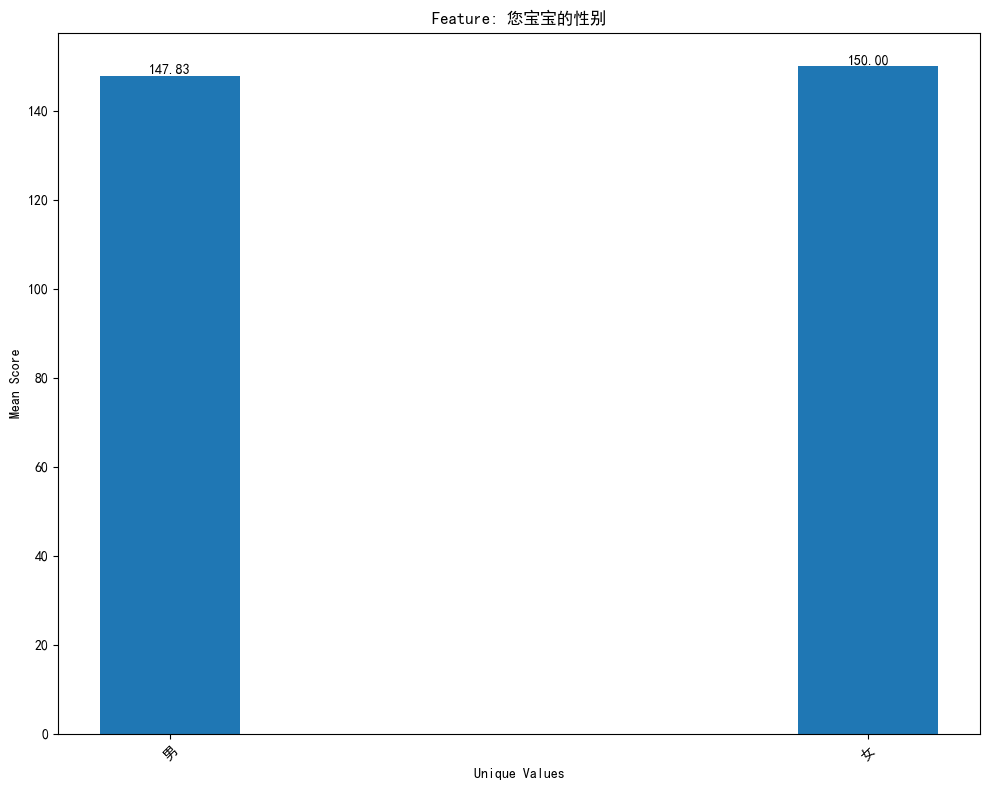

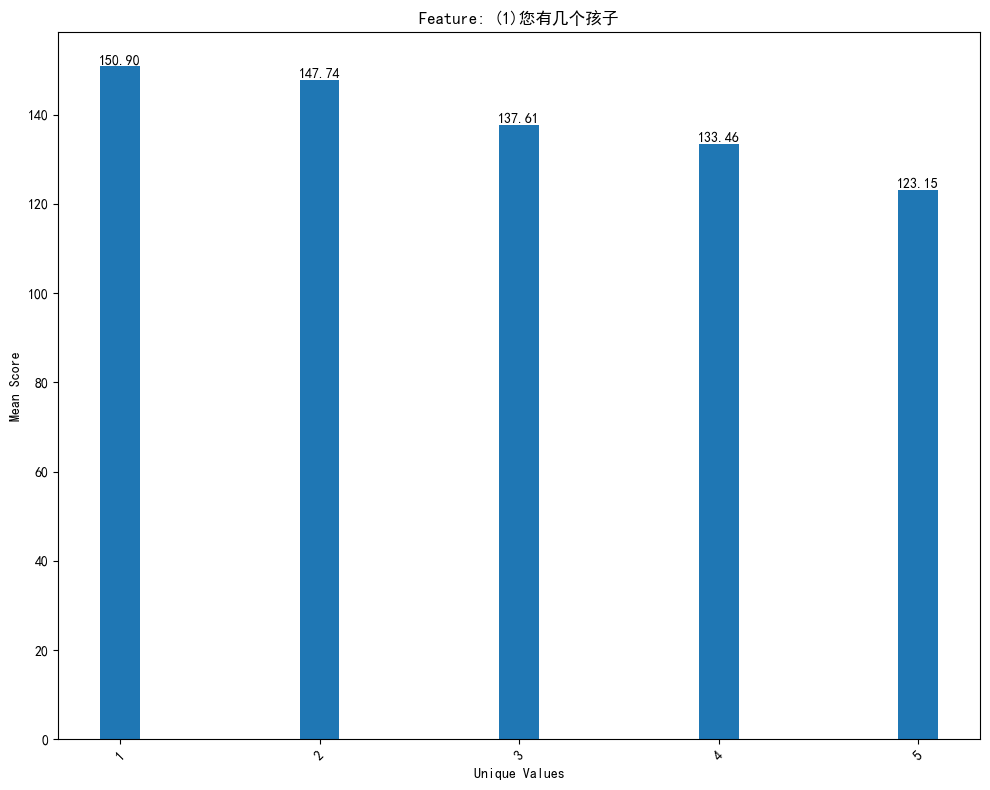

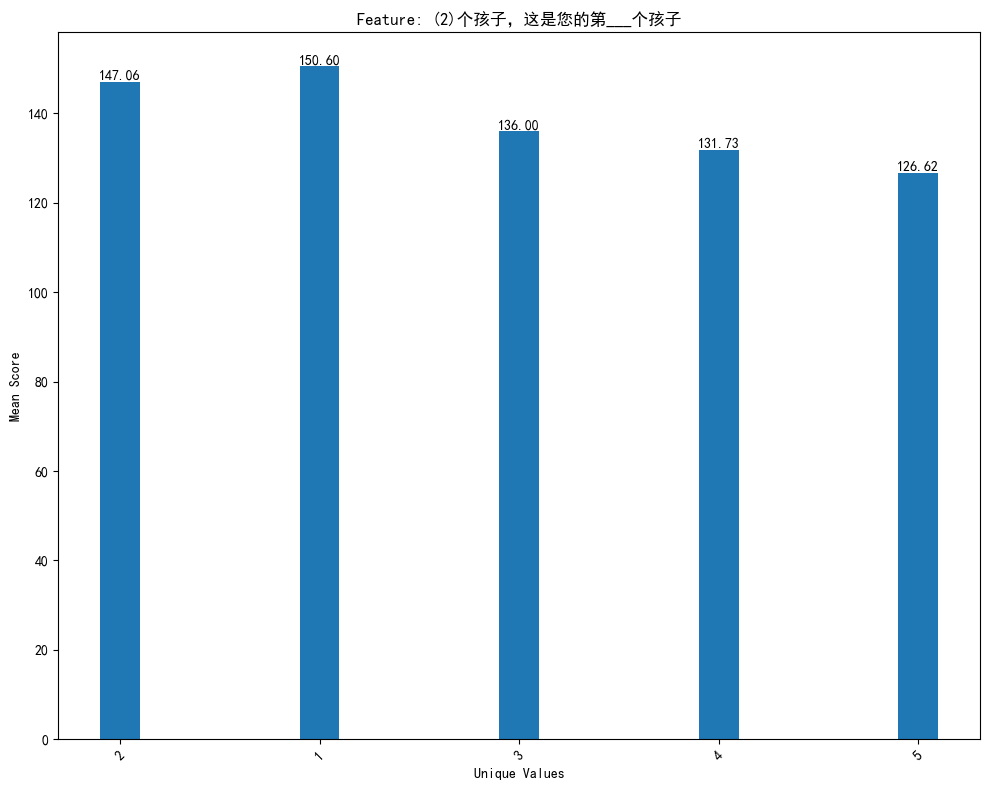

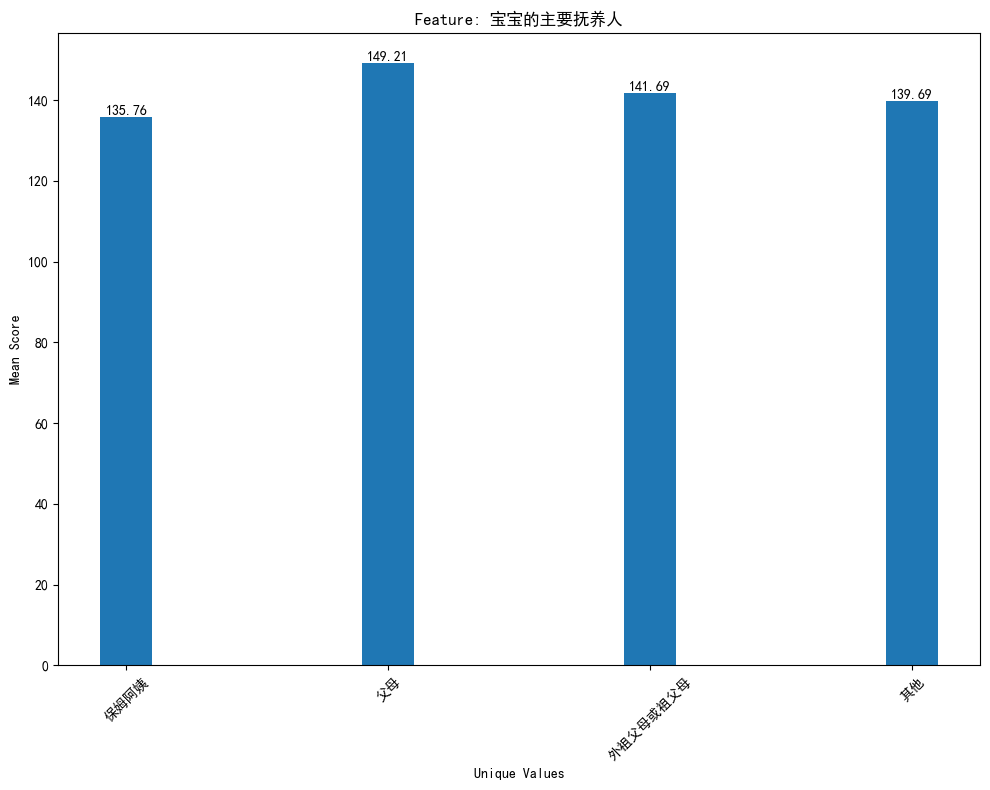

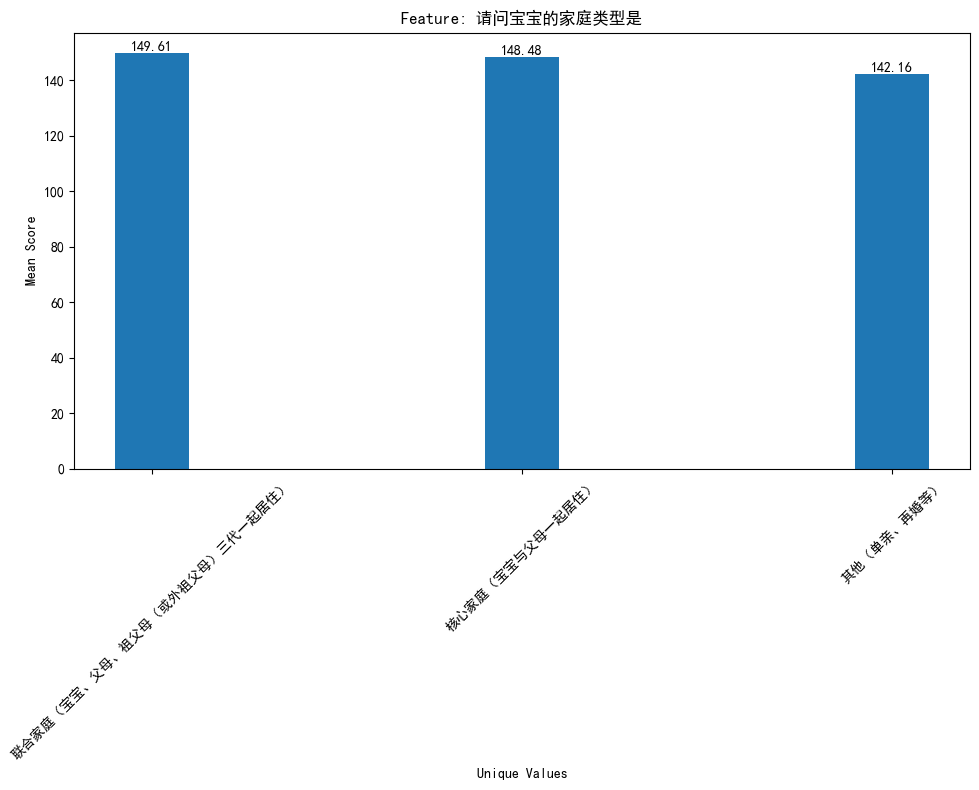

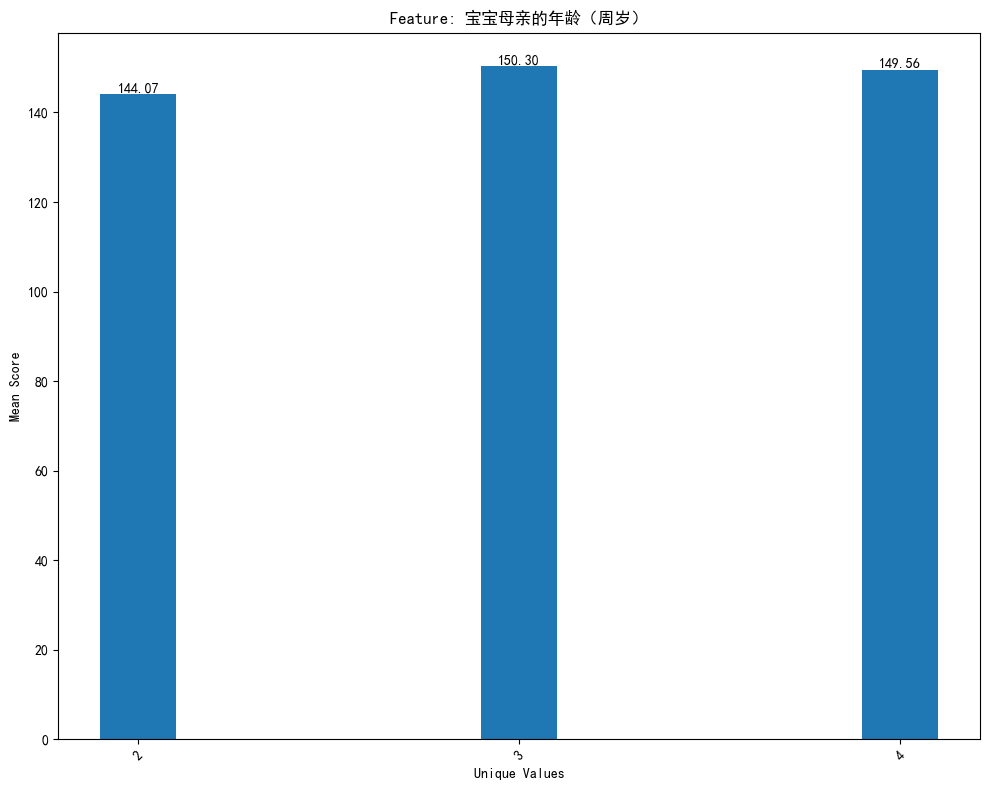

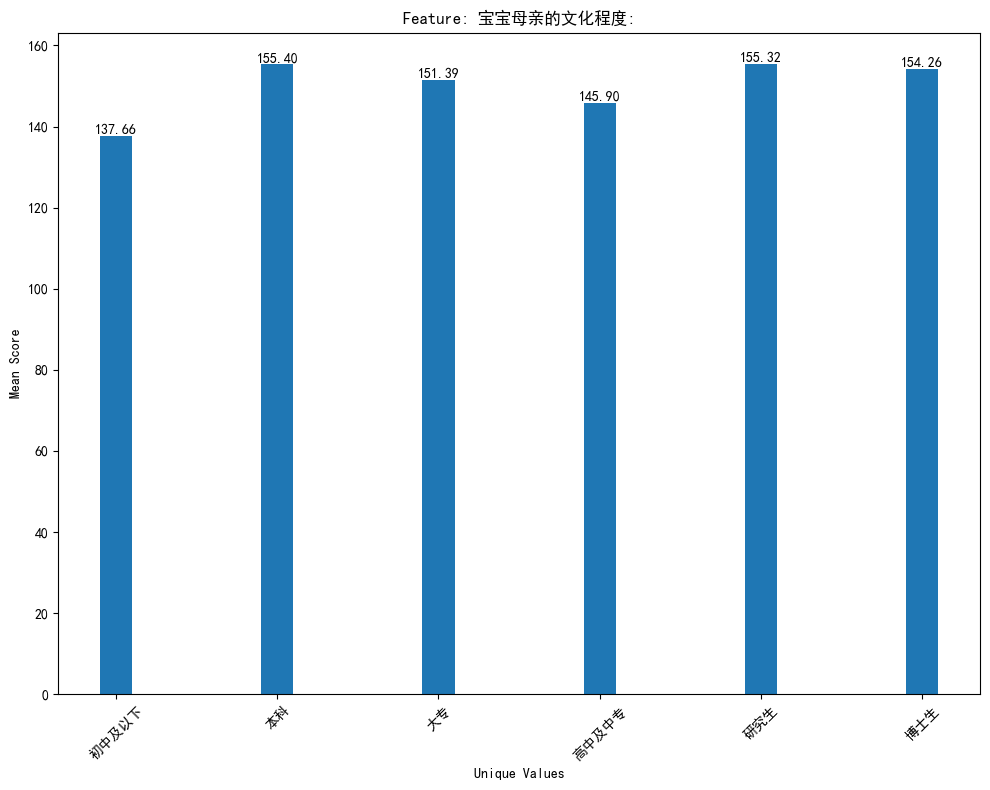

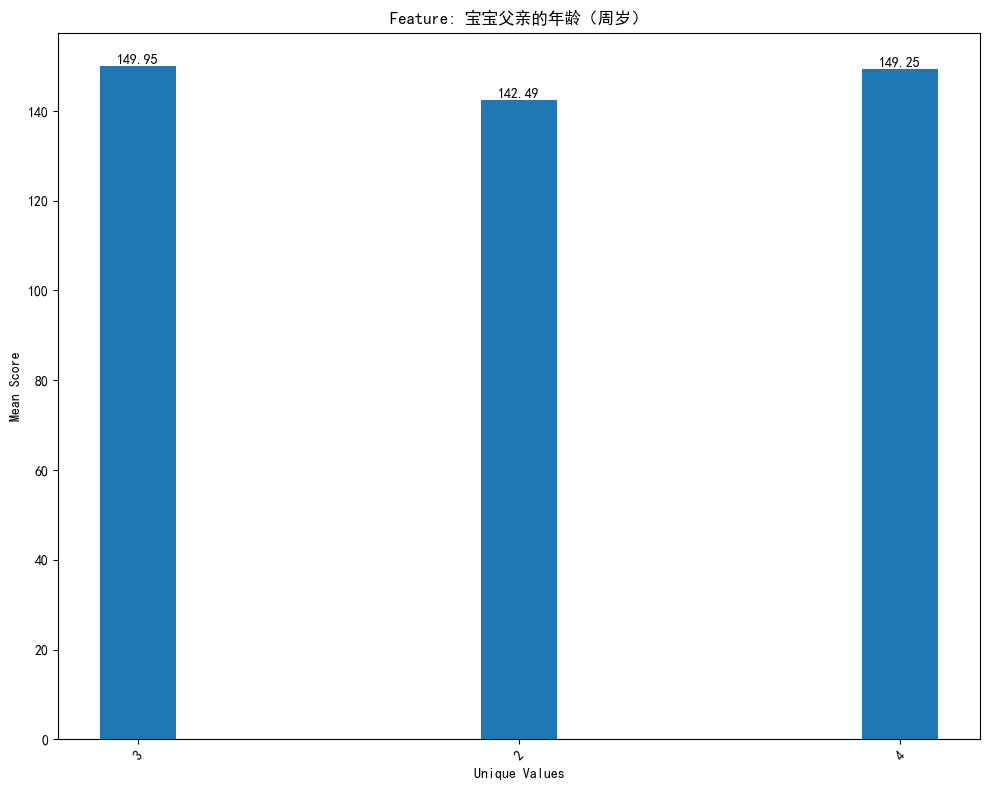

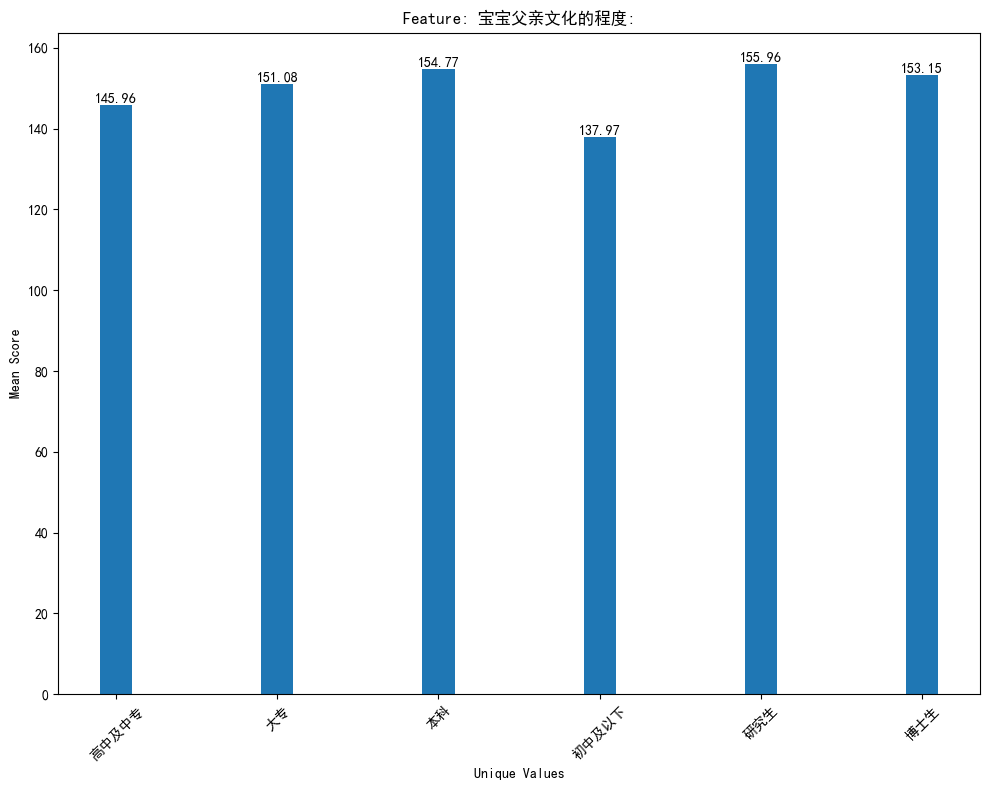

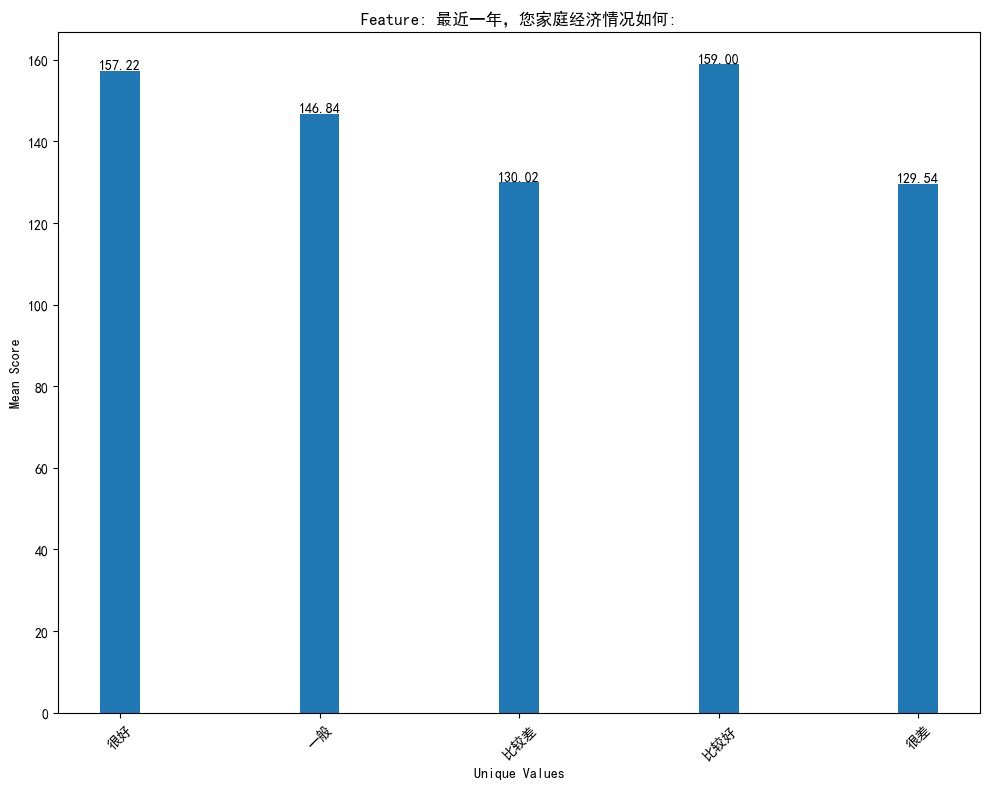

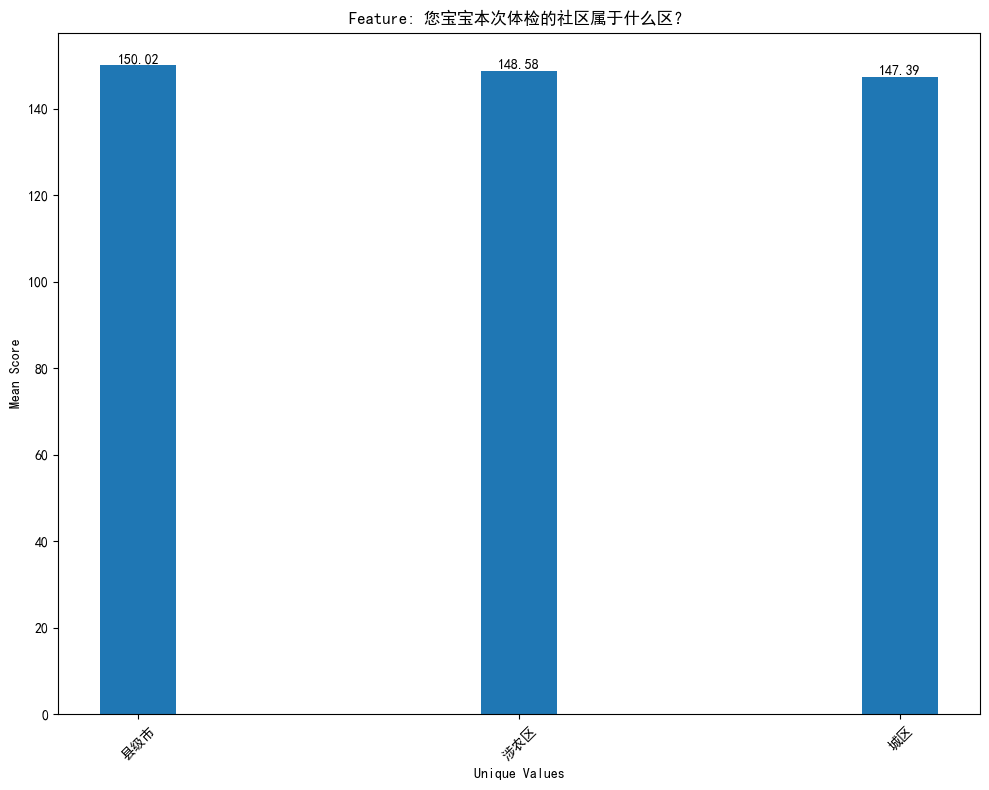

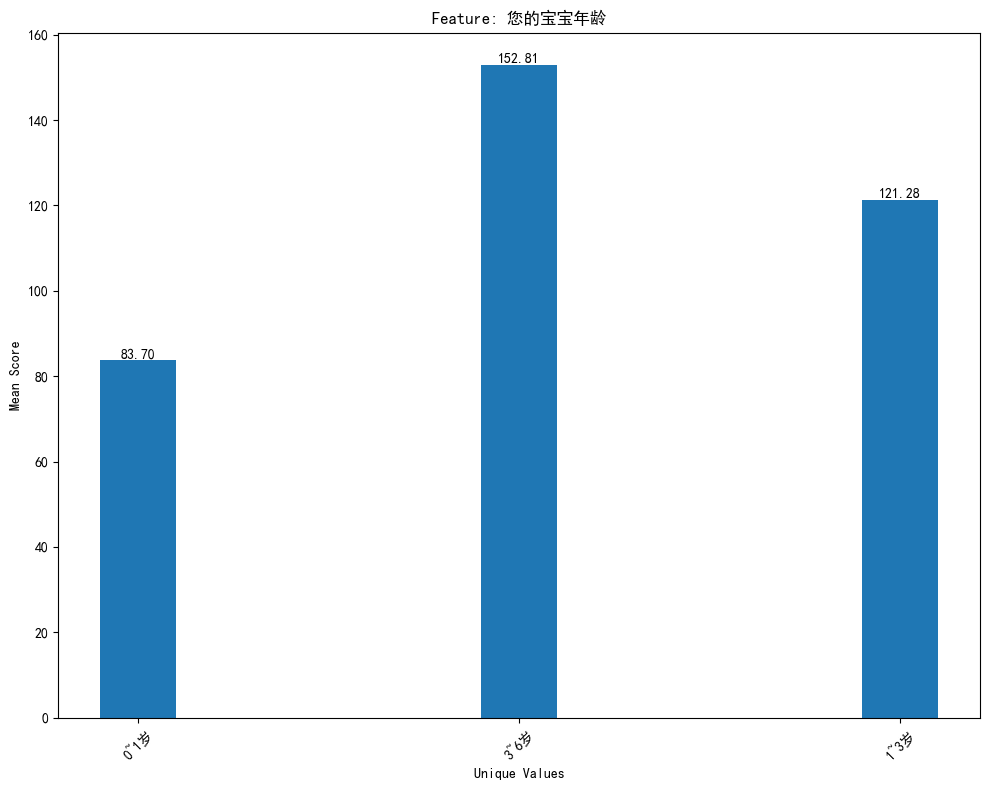

In [51]:
import matplotlib.pyplot as plt

# 设置Matplotlib的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 假设data是一个DataFrame，其中包含了各个特征和总分
# 假设target是一个DataFrame，包含了总分
# feature[1:base_info_idx] 包含了需要分类的特征名

cnt = 0
for feature_name in feature[1:base_info_idx]:
    cnt += 1
    unique_values = data[feature_name].unique()
    scores_means = []
    for value in unique_values:
        # 根据当前特征值筛选数据
        selected_data = data[data[feature_name] == value]
        # 获取这些数据的索引
        selected_indices = selected_data.index
        # 根据索引获取总分
        selected_scores = target.iloc[selected_indices]
        # 计算平均分
        mean_score = selected_scores.mean().values[0]
        scores_means.append(mean_score)
    
    # 绘制条形图
    plt.figure(figsize=(10, 8))
    # plt.bar(range(len(unique_values)), scores_means, tick_label=[encoder(v, dicList[cnt]) for v in unique_values], width=0.2)
    bars = plt.bar(range(len(unique_values)), scores_means, tick_label=[encoder(v, dicList[cnt]) for v in unique_values], width=0.2)
    plt.title(f'Feature: {feature_name}')
    plt.xlabel('Unique Values')
    plt.ylabel('Mean Score')
    plt.xticks(rotation=45)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2., height, f'{height:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()